In [62]:
# Importing all of the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Loading the notebook cofigurations
import yaml
with open("../notebook_config.yaml", "rb") as f:
    config = yaml.safe_load(f)
    X_train_eng, X_val_eng, X_test_eng = config['paths']["X_train_eng"], config['paths']["X_val_eng"], config['paths']["X_test_eng"]
    y_train_eng, y_val_eng, y_test_eng = config['paths']["y_train_eng"], config['paths']["y_val_eng"], config['paths']["y_test_eng"]
    
    X_train_raw, X_val_raw, X_test_raw = config['paths']["X_train_raw"], config['paths']["X_val_raw"], config['paths']["X_test_raw"]
    y_train_raw, y_val_raw, y_test_raw = config['paths']["y_train_raw"], config['paths']["y_val_raw"], config['paths']["y_test_raw"]

    X_train, X_val, X_test = config['paths']["X_train"], config['paths']["X_val"], config['paths']["X_test"]
    y_train, y_val, y_test = config['paths']["y_train"], config['paths']["y_val"], config['paths']["y_test"]

In [64]:
# Load engineered features and labels
X_train_eng = pd.read_csv(X_train_eng)
X_val_eng = pd.read_csv(X_val_eng)
X_test_eng = pd.read_csv(X_test_eng)
y_train_eng = pd.read_csv(y_train_eng).squeeze()
y_val_eng = pd.read_csv(y_val_eng).squeeze()
y_test_eng = pd.read_csv(y_test_eng).squeeze()

# Load raw features and labels
X_train_raw = pd.read_csv(X_train_raw)
X_val_raw = pd.read_csv(X_val_raw)
X_test_raw = pd.read_csv(X_test_raw)
y_train_raw = pd.read_csv(y_train_raw).squeeze()
y_val_raw = pd.read_csv(y_val_raw).squeeze()
y_test_raw = pd.read_csv(y_test_raw).squeeze()

# Load the main split as well
X_train = pd.read_csv(X_train)
X_val = pd.read_csv(X_val)
X_test = pd.read_csv(X_test)
y_train = pd.read_csv(y_train).squeeze()
y_val = pd.read_csv(y_val).squeeze()
y_test = pd.read_csv(y_test).squeeze()

In [65]:
# Initializing a Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Initializing the model
rf_v1_eng = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    min_samples_split=12,
    min_samples_leaf=10,
    max_features='sqrt'
)

In [66]:
# Code for plotting the learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, title, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label=f'Training {scoring}')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label=f'Validation {scoring}')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel(f'{scoring}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Custom Scorer for the Recall of the malignancy class
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
recall_malignant = make_scorer(recall_score, pos_label=1)

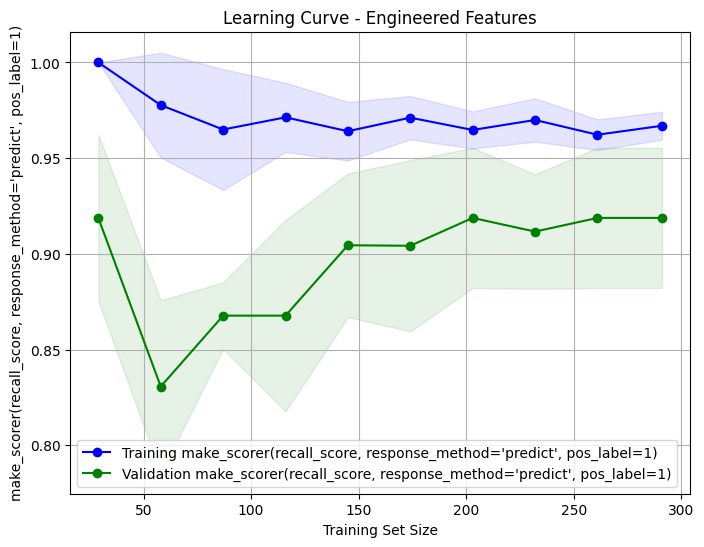

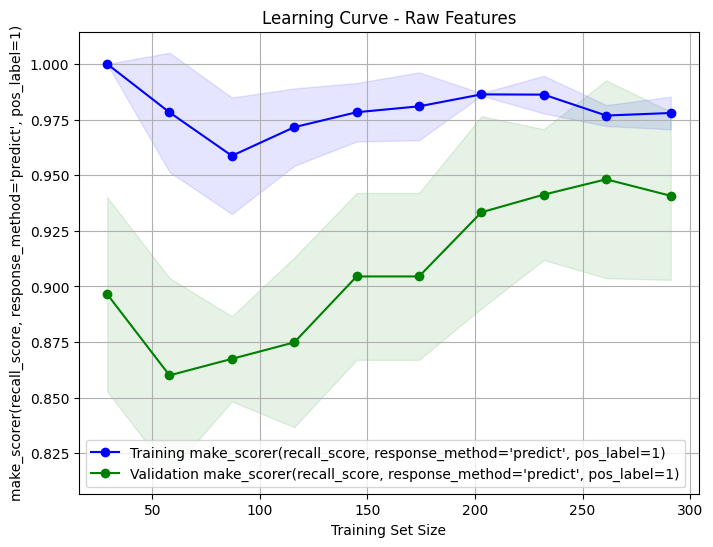

In [67]:
# Plotting the learning curves
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold instance
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Plot on engineered features
plot_learning_curve(
    rf_v1_eng, X_train_eng, y_train_eng, 
    'Learning Curve - Engineered Features', 
    cv=stratified_cv, scoring=recall_malignant
)
# Plot on raw features
plot_learning_curve(
    rf_v1_eng, X_train_raw, y_train_raw, 
    'Learning Curve - Raw Features', 
    cv=stratified_cv, scoring=recall_malignant
)

In [68]:
# Cross Validation for robust, unbiased estimates of your model’s real-world performance on the selected scoring metric
from sklearn.model_selection import cross_validate

# Some more scoring tailored towards malignant cases
precision_malignant = make_scorer(precision_score, pos_label=1)
f1_malignant = make_scorer(f1_score, pos_label=1)
scoring = {
    'recall_malignant': recall_malignant,
    'precision_malignant': precision_malignant,
    'f1_malignant': f1_malignant
}
# Cross-validation with multiple scoring metrics on Engineered features
cv_results_eng = cross_validate(
    rf_v1_eng, X_train_eng, y_train_eng, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

# Cross-validation with multiple scoring metrics on Raw features
cv_results_raw = cross_validate(
    rf_v1_eng, X_train_raw, y_train_raw, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

# Print results summary for Engineered Features
for metric in scoring.keys():
    scores = cv_results_eng[f'test_{metric}']
    print(f"Engineered Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

# Print results summary for Raw Features
for metric in scoring.keys():
    scores = cv_results_raw[f'test_{metric}']
    print(f"Raw Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

Engineered Features - recall_malignant: 0.919 ± 0.037
Engineered Features - precision_malignant: 0.874 ± 0.071
Engineered Features - f1_malignant: 0.894 ± 0.036
Raw Features - recall_malignant: 0.948 ± 0.044
Raw Features - precision_malignant: 0.890 ± 0.073
Raw Features - f1_malignant: 0.916 ± 0.041


In [69]:
from sklearn.model_selection import RandomizedSearchCV

# Define malignant and benign recall scorers
recall_malignant = make_scorer(recall_score, pos_label=1)
recall_benign = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

# Define hyperparameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 4, 8, 12],
    'min_samples_leaf': [1, 4, 8, 12],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameter tuning for Engineered Features
random_search_eng = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',  # Select best model using malignant recall
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_eng.fit(X_train_eng, y_train_eng)
print("Best Parameters (Engineered):", random_search_eng.best_params_)

# Hyperparameter tuning for Raw Features
random_search_raw = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_raw.fit(X_train_raw, y_train_raw)
print("Best Parameters (Raw):", random_search_raw.best_params_)

# Access best estimators after tuning
best_rf_eng = random_search_eng.best_estimator_
best_rf_raw = random_search_raw.best_estimator_

# Access cv results if needed
results_eng = random_search_eng.cv_results_
results_raw = random_search_raw.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Engineered): {'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 6, 'class_weight': 'balanced_subsample'}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Raw): {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 5, 'class_weight': 'balanced'}


In [70]:
# Classification report on the Validation Splits
from sklearn.metrics import classification_report

# Predict on validation set with best estimator from engineered feature pool
y_val_pred_eng = best_rf_eng.predict(X_val_eng)
print("Classification Report - Engineered Features Validation Set")
print(classification_report(y_val_eng, y_val_pred_eng, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from engineered feature pool
y_test_pred_eng = best_rf_eng.predict(X_test_eng)
print("Classification Report - Engineered Features Test Set")
print(classification_report(y_test_eng, y_test_pred_eng, target_names=['Benign', 'Malignant']))

Classification Report - Engineered Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Engineered Features Test Set
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [71]:
# Predict on validation set with best estimator from raw feature pool
y_val_pred_raw = best_rf_raw.predict(X_val_raw)
print("Classification Report - Raw Features Validation Set")
print(classification_report(y_val_raw, y_val_pred_raw, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from raw feature pool
y_test_pred_raw = best_rf_raw.predict(X_test_raw)
print("Classification Report - Raw Features Test Set")
print(classification_report(y_test_raw, y_test_pred_raw, target_names=['Benign', 'Malignant']))

Classification Report - Raw Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Raw Features Test Set
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



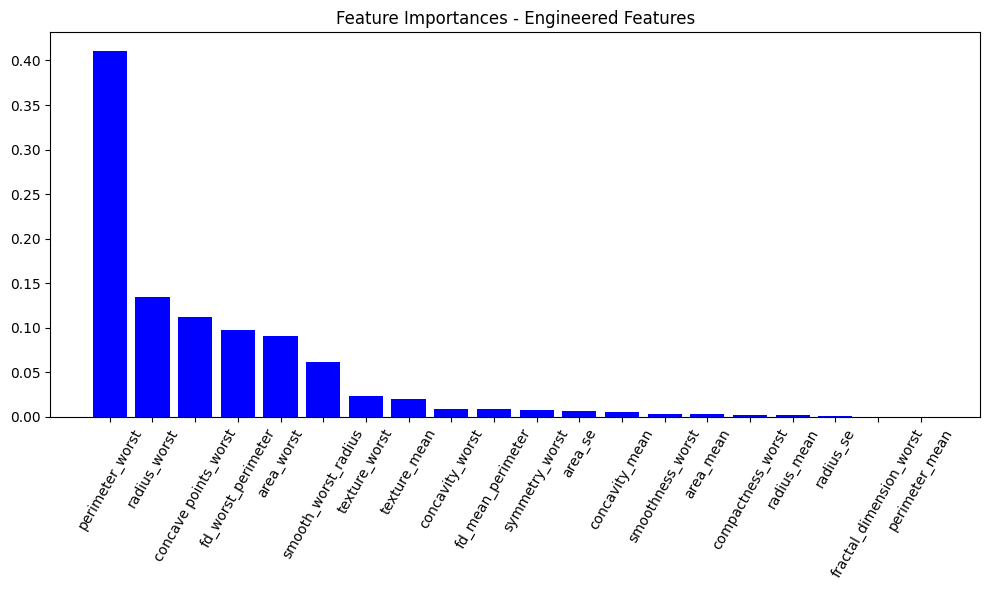

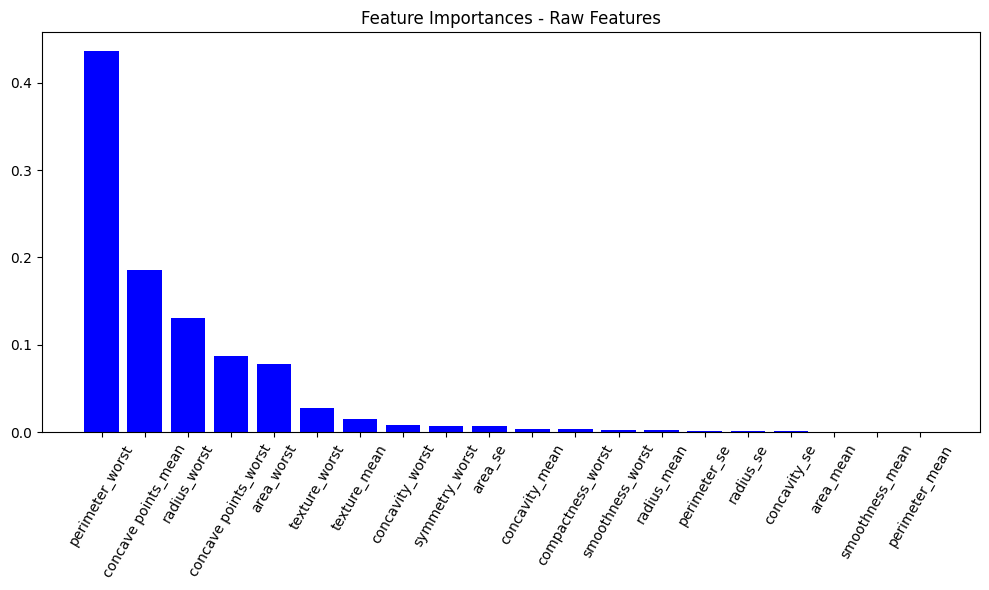

In [72]:
# Plotting the feature Importances
def plot_feature_importances(model, feature_names, title):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1]
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], color='b', align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=60)
    plt.tight_layout()
    plt.show()

# For engineered features
plot_feature_importances(best_rf_eng, X_train_eng.columns, "Feature Importances - Engineered Features")

# For raw features
plot_feature_importances(best_rf_raw, X_train_raw.columns, "Feature Importances - Raw Features")

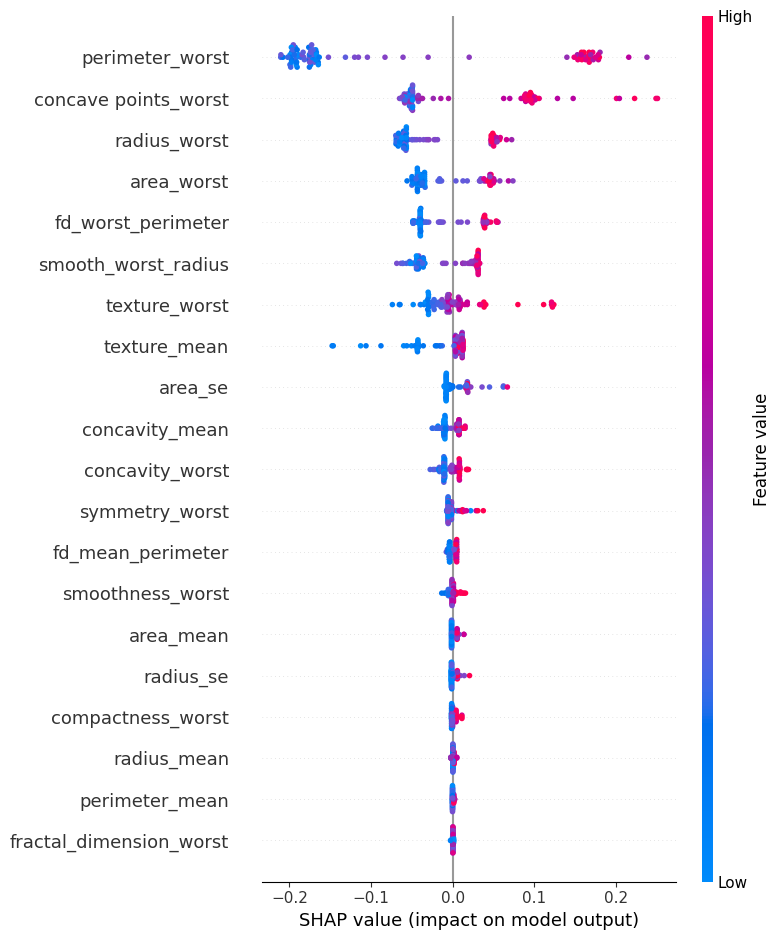

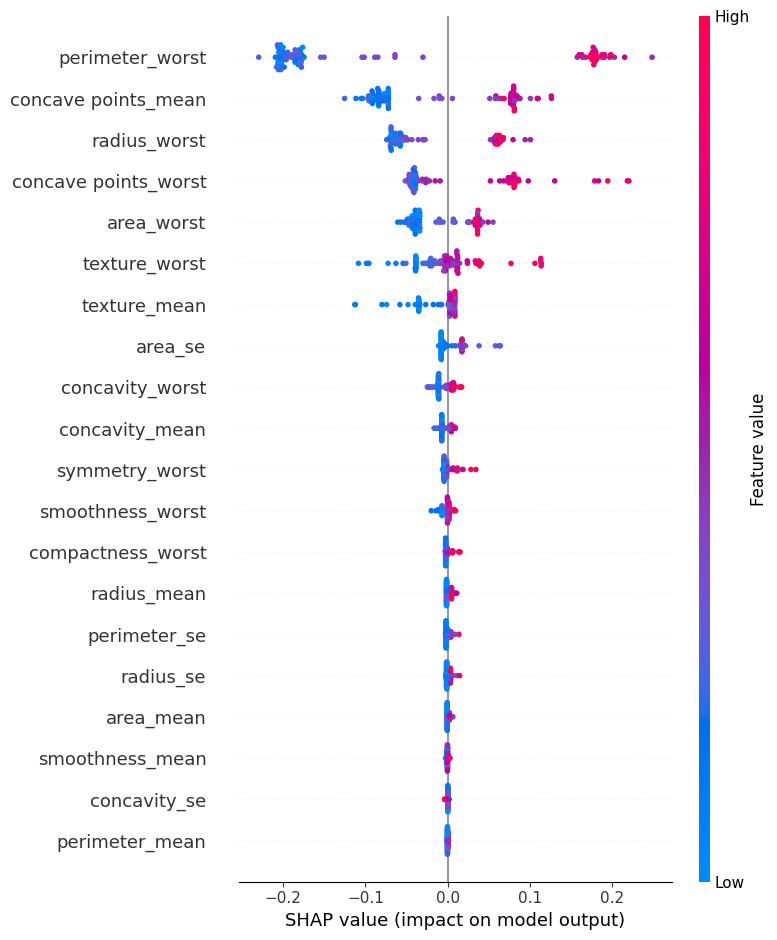

In [73]:
import shap

# Create TreeExplainer for your engineered features model
explainer_eng = shap.TreeExplainer(best_rf_eng)

# Calculate SHAP values for the validation set
shap_values_eng = explainer_eng.shap_values(X_val_eng)

# Plot SHAP summary for engineered features
shap.summary_plot(shap_values_eng[:,:,1], X_val_eng, feature_names=X_val_eng.columns, title="SHAP Summary - Engineered Features")


# Create TreeExplainer for your raw features model
explainer_raw = shap.TreeExplainer(best_rf_raw)

# Calculate SHAP values for the validation set
shap_values_raw = explainer_raw.shap_values(X_val_raw)

# Plot SHAP summary for raw features
shap.summary_plot(shap_values_raw[:,:,1], X_val_raw, feature_names=X_val_raw.columns, title="SHAP Summary - Raw Features")


In [74]:
def select_features_above_threshold(model, feature_names, threshold):
    importances = model.feature_importances_
    selected = [(feature, imp) for feature, imp in zip(feature_names, importances) if imp >= threshold]
    # Sort by importance descending
    selected_sorted = sorted(selected, key=lambda x: x[1], reverse=True)
    return selected_sorted

# Select features above threshold from engineered features
selected_eng = select_features_above_threshold(best_rf_eng, X_train_eng.columns, threshold=0.04)
print("Selected Engineered Features:", [f[0] for f in selected_eng])

# Select features above threshold from raw features
selected_raw = select_features_above_threshold(best_rf_raw, X_train_raw.columns, threshold=0.08)
print("Selected Raw Features:", [f[0] for f in selected_raw])

# Combine unique features, preserving importance (choose max importance if duplicated)
combined_dict = {}

for feature, importance in selected_eng + selected_raw:
    if feature in combined_dict:
        combined_dict[feature] = max(combined_dict[feature], importance)
    else:
        combined_dict[feature] = importance

# Sort combined features by importance descending
combined_sorted = sorted(combined_dict.items(), key=lambda x: x[1], reverse=True)
combined_features = [f[0] for f in combined_sorted]

print("Combined Unique Features:", len(combined_features))

Selected Engineered Features: ['perimeter_worst', 'radius_worst', 'concave points_worst', 'fd_worst_perimeter', 'area_worst', 'smooth_worst_radius']
Selected Raw Features: ['perimeter_worst', 'concave points_mean', 'radius_worst', 'concave points_worst']
Combined Unique Features: 7


In [75]:
X_train_combined = X_train[combined_features]
X_val_combined = X_val[combined_features]
X_test_combined = X_test[combined_features]
y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

In [76]:
rf_combined = RandomForestClassifier(random_state=42, n_jobs=-1)

recall_malignant = make_scorer(recall_score, pos_label=1)
recall_benign = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

# Define hyperparameter distribution to search
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_search = RandomizedSearchCV(
    estimator=rf_combined,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
# Fit on combined training data
random_search.fit(X_train_combined, y_train_combined)

# Best params and estimator
print("Best Hyperparameters:", random_search.best_params_)
best_rf_combined = random_search.best_estimator_

# Validate on validation set
y_val_pred = best_rf_combined.predict(X_val_combined)
print("Validation Classification Report:\n", classification_report(y_val_combined, y_val_pred))

# Test performance
y_test_pred = best_rf_combined.predict(X_test_combined)
print("Test Classification Report:\n", classification_report(y_test_combined, y_test_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'class_weight': 'balanced_subsample'}
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96        57
           1       0.91      0.94      0.93        34

    accuracy                           0.95        91
   macro avg       0.94      0.94      0.94        91
weighted avg       0.95      0.95      0.95        91

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

